In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

### Data Preprocessing
Integrating datasets into two data frames, True and False

In [ ]:
df1 = pd.read_csv('Data/archive/Fake.csv')
df1['label'] = 'Fake'
del df1['subject']
del df1['date']

In [ ]:
df2 = pd.read_csv('Data/archive/True.csv')
df2['label'] = 'True'
del df2['subject']
del df2['date']

In [ ]:
df3 = pd.read_csv('Data/fake_or_real_news.csv')
del df3['Unnamed: 0']
df3['label'] = df3['label'].replace(['FAKE', 'REAL'], ['Fake', 'True'])

In [ ]:
df4 = pd.read_csv('Data/fake.csv')
df4['label'] = 'Fake'
df4 = df4[['title', 'text', 'label']].copy()

In [ ]:
frames = [df1, df2, df3, df4]
data = pd.concat(frames)
data.sample(20)

### Modified data quality report
Helps determine what further cleaning needs to be done

In [ ]:
# Constructing a data quality report for the data
cat_data = {'Feature': ['title', 'text', 'label'],
            'Count': data.count(),
            '% Missing': data.isnull().sum() * 100 / len(data),
            'Cardinality': data.apply(pd.Series.nunique),
            'Mode': [data.mode()['title'][0], 'null', data.mode()['label'][0]],
            'Mode Freq.': ['14', '769', '39644'],
            'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
    
            'Notes': ['', '', '']}
cat_dqr_df = pd.DataFrame(cat_data)
cat_dqr_df.reset_index(drop=True, inplace=True)
cat_dqr_df

In [ ]:
data.drop_duplicates(inplace = True)

dfTrue = data[data['label'] == 'True']
dfFake = data[data['label'] == 'Fake']

dfFake.info()
dfTrue.info()

In [ ]:
p = 0.2  # Keep 20% of the data.
dfTrue = dfTrue.head(int(p * dfTrue.shape[0]))
dfFake = dfFake.head(int(p * dfFake.shape[0]))

### Data Cleaning
Removing stopwords, punctuation, and whitespace characters

In [ ]:
def clean_string(input):
    stops = set(stopwords.words("english"))  # Set of stopwords

    input_tokenized = word_tokenize(input)   # Tokenize input
    input_without_sw = [word for word in input_tokenized if not word in stops]  # Remove stopwords
    input = (" ").join(input_without_sw)  # Combine back into sentence

    input = input.lower()
    input = re.sub('\n|\r|\t', '', input)   # Remove whitespace chars
    input = re.sub(r'[^\w\s]+', '', input)  # Remove punctuation
    
    
    return input

def preprocess(df):
    df.dropna(axis=0, inplace = True)  # Remove rows with missing values
    cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
    df['title'] = cleanfunc(df['title'])
    df['text'] = cleanfunc(df['text'])
    return df

In [ ]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

### Feature Extraction & Visualization
a) Character count in Title and Text

In [26]:
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]


def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='Type of News', legend=False,
                    ylabel='Characters', title=f'Average char count of {field} field in each type of news')  
  plt.xticks(rotation=0)
  plt.show()
  

def char_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

In [ ]:
char_stats(dfTrue, dfFake, 'title')
char_stats(dfTrue, dfFake, 'text')

Word Count Distribution of title


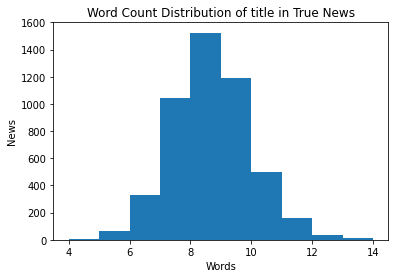

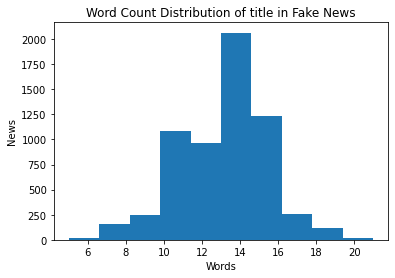

Average count of title


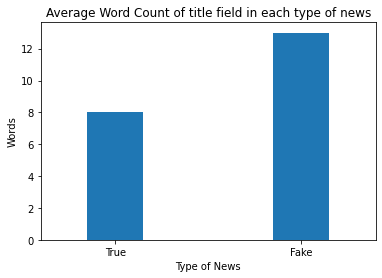

In [30]:
vectorizer = CountVectorizer()

def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='Type of News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field} field in each type of news')  
  plt.xticks(rotation=0)
  plt.show()
  

def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)

word_stats(dfTrue, dfFake, 'title')